# Notebook for crowdsourcing experiments for ChartFC Wikicommons dataset

## Overview 
This notebook executes the crowdsourcing experiments for the three different tasks 


1. <strong>Generate tasksets </strong>


2. <strong>Label gold tasks </strong>


3. <strong>Sent tasks to Mechanical Turk for annotation</strong> 


4. <strong>Frequently update task with workers' answers</strong> 

Set the following constants first:


#### Importing packages

In [1]:
# Load packages 

import bs4 
import boto3
import botocore
import botocore.exceptions
import copy
# import dns
import json
import certifi

import numpy as np
import os
import pandas as pd
import pymongo
import random
import requests
import uuid

from bs4 import BeautifulSoup
from collections import OrderedDict
from datetime import datetime
from pprint import pprint
from pymongo import MongoClient, InsertOne
import pdb

from decimal import Decimal
from decimal import *
import matplotlib.pyplot as plt
import math
import xmltodict

random.seed(10)


In [169]:
# VARIABLES 

PROJECT_PATH = r"/Users/user/Library/CloudStorage/OneDrive-King'sCollegeLondon/PycharmProjects/chartfc_dataset_wikicommons"

# Folder containing all data files for crowdsourcing
DATA_FOLDER = os.path.join(PROJECT_PATH, 'data')

# Folder containing all config files for crowdsourcing
CONFIG_FOLDER = os.path.join(PROJECT_PATH, 'config')
TASK_CONFIG = os.path.join(CONFIG_FOLDER, 'task_config_{}.json') 

# Set path to .json file with crowdsourcing qualification tests
PATH_QUALIFICATION_TESTS = os.path.join(PROJECT_PATH, 'data/mturk/qualification_tests.json')

# Set task type as one of the following: 'table_annotation', 'claim_generation', 'adjusted_claim_annotation'
TASK_TYPE_LIST = ["chart_filtering", "claim_explanation_generation", "claim_explanation_verification", "explanation_verification"]
TASK_TYPE = TASK_TYPE_LIST[2] # selected task type

# Set to 1 if crowdsourcing tasks in production should be created, else 0 for test
CREATE_HITS_IN_PRODUCTION = 1 # !!! DONT CHANGE THIS 

# Set 1 if current taskSet (if existing) should be updated
UPDATE_TASKSETS_CHART_FILTERING = 0
UPDATE_TASKSETS_CLAIM_EXPLANATION_GENERATION = 0

# Set path to db credentials, used for storing crowdsourcing tasks and results 
PATH_MONGODB_CREDENTIALS = os.path.join(PROJECT_PATH, 'config/mongodb_credentials.json')

# Set path to amazon credentials saved in a .json file
PATH_AMAZON_CREDENTIALS = os.path.join(PROJECT_PATH, 'config/amazon_credentials.json')

# Set Amazon mturk endpoint used for crowdsourcing experiments
MTURK_ENDPOINT = 'https://mturk-requester.us-east-1.amazonaws.com'
MTURK_ENDPOINT_SANDBOX = 'https://mturk-requester-sandbox.us-east-1.amazonaws.com'

WORKER_BAN_LIST = os.path.join(PROJECT_PATH, f'config/banlist_{TASK_TYPE}.json')

# Path to save created tasks for a task 
PATH_TASKSETS_FOLDER = os.path.join(DATA_FOLDER, "mturk", "tasksets")
PATH_PRE_TASKSETS = os.path.join(PATH_TASKSETS_FOLDER, "{}_pre_tasksets.json")
PATH_PRE_TASKSETS_GOLD = os.path.join(PATH_TASKSETS_FOLDER, "{}_pre_tasksets_gold.json")
PATH_PRE_TASKSETS_NON_GOLD = os.path.join(PATH_TASKSETS_FOLDER, "{}_pre_tasksets_non_gold.json")
PATH_TASKSETS = os.path.join(PATH_TASKSETS_FOLDER, "{}_tasksets.json")

# Paths to html files
PATH_HTML_TEXT = os.path.join(DATA_FOLDER, "mturk", "html_text")
PATH_HTML_TEMPLATE = os.path.join(PROJECT_PATH, "code", "html_files")


In [216]:
# Ban workers which are spammers after pilot round 

to_ban = True
if to_ban:
    with open(WORKER_BAN_LIST,'r') as f:
        banlist = json.load(f)
    for w in banlist:
        try:
            print(w)
            response = mt.client.create_worker_block(WorkerId=w, Reason='Malicious behaviour.')
            assert(response['ResponseMetadata']['HTTPStatusCode'] == 200)
        except botocore.exceptions.ClientError as e:
            print(f"Following exception thrown ", e)
            continue
    print(f"{len(banlist)} workers banned in total.")
    
else: 
    print("No worker banned.")
            

A2YDW8YH92OTMJ
AHIEGG1CIF8HI
A2E01QC59QLRV0
A2YDW8YH92OTMJ
A1BX9HAQ85WQV1
A1AOOWER2J623J
A16MEV9DI9VMAW
A32YOD79DL837P
A2Z0OH990725SA
ASLGN9PS93UYR
10 workers banned in total.


---------------

In [43]:
with open(PATH_QUALIFICATION_TESTS,'r') as f:
    qualification_tests = json.load(f)


In [5]:
# MongoDB connection

with open(PATH_MONGODB_CREDENTIALS,'r') as f:
    mongodb_credentials = json.load(f)

# Connect to Mong\oDB
db_client = pymongo.MongoClient(mongodb_credentials["connection_string"], tlsCAFile=certifi.where()) # connecting to database
db = db_client['chartfc']


In [171]:
# select dataset table to save results 

if TASK_TYPE == "chart_filtering": 
    hit_result_collection = db.hit_results if CREATE_HITS_IN_PRODUCTION else db.hit_results_sandbox
elif TASK_TYPE == "claim_explanation_generation": 
    hit_result_collection = db.hit_results_claim_explanation_generation if CREATE_HITS_IN_PRODUCTION else db.hit_results_sandbox_claim_explanation_generation
elif TASK_TYPE == "claim_explanation_verification":
    hit_result_collection = db.hit_results_claim_explanation_verification if CREATE_HITS_IN_PRODUCTION else db.hit_results_sandbox_claim_explanation_verification
    

In [172]:
# Mturk client

class MTurk():

    def __init__(self):
        with open(PATH_AMAZON_CREDENTIALS)  as f: # get the credentials from AMT 
            cfg = json.load(f)

        self.access_key = cfg['access_key']
        self.secret_key = cfg['secret_key']
        
        self.environments = {
            "production": {
                "endpoint": MTURK_ENDPOINT, # set mturk endpoint
                "preview": "https://www.mturk.com/mturk/preview"
            },
            "sandbox": {
                "endpoint": MTURK_ENDPOINT_SANDBOX, # set mturk endpoint
                "preview": "https://workersandbox.mturk.com/mturk/preview"
            },
        }

    def launch_client(self, production = False):
        self.mturk_environment = self.environments["production"] if production else self.environments["sandbox"]
        try:
            session = boto3.Session(profile_name='mturk')
        except botocore.exceptions.ProfileNotFound as e:
            session = boto3.Session(
                profile_name='mturk',
                aws_access_key_id  = self.access_key,
                aws_secret_access_key  = self.secret_key
            )
        self.client = session.client(
            service_name= 'mturk',
            region_name= 'us-east-1',
            endpoint_url= self.mturk_environment['endpoint'],
        )
        print(self.client.get_account_balance()['AvailableBalance'])

    def create_hit(self, html_layout, **TaskAttributes):
        QUESTION_XML = """<HTMLQuestion xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2011-11-11/HTMLQuestion.xsd"><HTMLContent><![CDATA[{}]]></HTMLContent><FrameHeight>650</FrameHeight></HTMLQuestion>"""
        question_xml = QUESTION_XML.format(html_layout)
        
#         print(f"question_xml: {question_xml}")
        
        try:
            response = self.client.create_hit(
            **TaskAttributes,
                Question=question_xml
            )
        except Exception:
            with open('question_debug.xml','w+') as f:
                f.write(question_xml)
            print(f"question_xml is {question_xml}.")
            raise

        return response
    
    def get_hit_status(self, HITId):
        hit = self.client.get_hit(HITId=HITId)
        hit_status = hit['HIT']['HITStatus']
        return hit_status

    def get_hit_answers(self, HITId, approve=False):

        # Get list and number of Assignments that have been completed
        hit_assignmentsList = self.client.list_assignments_for_hit(
            HITId=HITId,
            AssignmentStatuses=['Submitted','Approved']
        )

        assignments = hit_assignmentsList['Assignments']

        # Get details and results of each Assignment and add to answers array
        answers = []
        for assignment in assignments:
            worker_id = assignment['WorkerId']
            assignment_id = assignment['AssignmentId']

            answer_dict = xmltodict.parse(assignment['Answer'])['QuestionFormAnswers']['Answer']
            values = {}
            for entry in answer_dict:
                try:
                    values[entry['QuestionIdentifier']] = json.loads(entry['FreeText'])
                except ValueError:
                    values[entry['QuestionIdentifier']] = entry['FreeText']
                except TypeError:
                    values[entry['QuestionIdentifier']] = None

            answer = {
                'worker_id' : worker_id,
                'assignment_id' : assignment_id,
                'values' : values,
                'HITId' : HITId
            }
            answers.append(answer)
            
            if approve:
                # Approve or not assignments
                if assignment['AssignmentStatus'] == 'Submitted':
                    self.client.approve_assignment(
                        AssignmentId = assignment_id,
                        OverrideRejection = False
                    )
                    
        return answers

In [173]:
# Connect to MTurk

mt = MTurk()
mt.launch_client(production = CREATE_HITS_IN_PRODUCTION)


4991.60


### Functions 


In [148]:
maxSingleInstances = 1 # MAX TIMES ANY REFERENCE APPEARS AMONG THE TASK SETS

def get_random_task(counter, n, non_gd_tasks):
    """Returns n random tasks of format (task, index) from list non_gd_tasks"""
    
    task_seq = []
    p = [max(maxSingleInstances-c,0.0001) for c in counter] # indexes of samples which can be used for task generation 
    p = [pp/sum(p) for pp in p]
    indexes = np.random.choice( # random choice of entries (given some constraints)
        a = list(range(len(non_gd_tasks))),
        size=n,
        replace=False, 
        p=p # samples used before in other tasks => probability set to 0 so that they are not chosen twice
    )        

    for i in indexes:
        task = non_gd_tasks[i]
        task_seq.append((task,i))
    
    return task_seq


def get_random_gd_task(n, gd_tasks):
    """Returns a sub-list of gd_tasks (ground truth) with n entries"""
    return random.sample(gd_tasks, n)


def generate_taskset(counter, non_gd_tasks, gd_tasks, n=(5,2)): # set the number of non-gold labelled tasks (e.g. 5) and gold labelled task (e.g. 2)
    '''
    counter = a counter which keeps track of how many times each reference was retrieved
    n = (x,y) where x = number of non_gd references and y = number of gd references
    '''
    taskSet = []
    
    task = get_random_task(counter, n[0], non_gd_tasks) # returns list of (index, sample)
    taskSet = [r for (r,i) in task] # pairs reference,index are generated here, so that we can update the counter later
    taskSet.extend(get_random_gd_task(n[1], gd_tasks))
    
    random.shuffle(taskSet) # gold standard should occur anywhere
    
    return taskSet, [i for (p,i) in task] # indixes returned to update counter


def generate_taskset_no_gold(counter, non_gd_tasks, n=5):
    """
    Generates taskset of n (default = 5) tasks and updates counter,
    so that a task appears only 'maxSingleInstances'-times in a taskSet
    """
    task_index_set = get_random_task(counter, n, non_gd_tasks) # returns list of (index, sample)
    taskSet = [r for (r,i) in task_index_set] # tasks extracted from the pairs of (task, index)
    
    return taskSet, [i for (p,i) in task_index_set] # indixes returned to update counter


def generate_taskset_w_ids(non_gd_tasks, gd_tasks, non_gold_per_taskset, gold_per_taskset) -> list:
    """
    Function to generate TaskSets given gold standards and other samples 
    """
    taskSets = []
    counter = [0]*len(non_gd_tasks) # keeping track if sample has been used before 

    while (any([c < maxSingleInstances for c in counter])):
        # generate task set with some random samples
        taskSet, indexes = generate_taskset(counter, non_gd_tasks, gd_tasks, n=(non_gold_per_taskset, gold_per_taskset)) 
        taskSetIDd = {
            '_id': str(uuid.uuid4()),
            'taskSet' : taskSet
        }
        taskSets.append(taskSetIDd) # add created taskSet with ID to list of taskSets 
        for i in indexes:
            # increase counter for samples added, so that they only appear 'maxSingleInstances'-times in a taskSet
            counter[i] = counter[i] + 1 
    
    return taskSets, counter


def generate_taskset_w_ids_no_gold(non_gd_tasks, n = 5) -> list:
    """
    Function to generate TaskSets given samples but without gold labelled samples 
    n (int): number of non_gold entries per taskSet
    """
    task_set_list = []
    counter = [0]*len(non_gd_tasks) # keeping track if sample has been used before 

    while (any([c < maxSingleInstances for c in counter])): # iterate as long as any sample in non_gd_tasks as not been used
        # generate task set with some random samples
        task_set, indexes = generate_taskset_no_gold(counter, non_gd_tasks, n) 
        task_set_w_id = {
            '_id': str(uuid.uuid4()),
            'taskSet' : task_set
        }
        
        task_set_list.append(task_set_w_id) # add created taskSet with ID to list of taskSets 
        for i in indexes:
            # increase counter for samples added, so that they only appear 'maxSingleInstances'-times in a taskSet
            counter[i] = counter[i] + 1 
    
    return task_set_list, counter
    

### 1. Generation of task sets


In [475]:
# Load data from MongoDB database for taskset creation

db_table = pd.DataFrame()

if TASK_TYPE == "chart_filtering": 
    db_table = db.chart_filtering
    cursor = db_table.find({"type": {"$regex": "(line_chart|pie_chart|barchart_vertical|barchart_horizontal)"}})# exclude scatterplots
    db_table = pd.DataFrame(list(cursor))
elif TASK_TYPE == "claim_explanation_generation": 
    db_table = db.chart_filtering
    cursor = db_table.find({"type": {"$regex": "(line_chart|pie_chart|barchart_vertical|barchart_horizontal)"},
                            "chart_filter_majority": 5
                           })# exclude scatterplots
    db_table = pd.DataFrame(list(cursor))
elif TASK_TYPE == "claim_explanation_verification": 
    db_table = db.hit_results_claim_explanation_generation
    cursor = db_table.find({'$or': [{'answers': {'$size': 1}}, {'answers': {'$size': 2}}, {'answers': {'$size': 3}}]})
    db_table = pd.DataFrame(list(cursor))
else:
    print(f"No table for task type {TASK_TYPE}")
    
print(f"Length of retrieved table: {len(db_table)}")

db_table.head(3)


Length of retrieved table: 463


,_id,batch_id,type,references,taskSet_id,hit,timestamp,answers
0,3PIOQ99R85KXJS7404KD8AU0849UNP,6d04f1db-91a4-44ae-a4b6-094bc769ffb3,claim_explanation_generation,"[{'db_id': '6390687199c9ed38aa871079', 'chart_...",9899f1d9-8f33-4d90-a601-93772a258e8c,"{'HITId': '3PIOQ99R85KXJS7404KD8AU0849UNP', 'H...",2023-03-28 17:30:06.785,"[{'worker_id': 'A1PZ6FQ0WT3ROZ', 'assignment_i..."
1,3PA41K45WU2VO27L3B4U27LB0937PO,00a7b61c-7975-4492-bc1b-0e322df899c2,claim_explanation_generation,"[{'db_id': '6390687199c9ed38aa870fb1', 'chart_...",b328066e-054f-45fd-b0e0-32ca6e54ae32,"{'HITId': '3PA41K45WU2VO27L3B4U27LB0937PO', 'H...",2023-03-29 09:41:31.100,"[{'worker_id': 'AFHD81VGCBAUJ', 'assignment_id..."
2,3VO4XFFP2CKGOE803OJJ2CBL55P7QF,00a7b61c-7975-4492-bc1b-0e322df899c2,claim_explanation_generation,"[{'db_id': '6390685299c9ed38aa870b3b', 'chart_...",09c75ca1-15b0-4ff3-85d8-540227de087a,"{'HITId': '3VO4XFFP2CKGOE803OJJ2CBL55P7QF', 'H...",2023-03-29 09:41:32.643,"[{'worker_id': 'A3CCFD0700KTPV', 'assignment_i..."


In [145]:
def create_tasks_chart_filtering(df): 
    """
    Function to create task set for the task chart filtering 
    df: database table for which to create task sets
    """
    
    # template for chart filtering tasks
    task_template = {
        "db_id": "",
        "chart_img": "https://chartfc.s3.amazonaws.com/{title}",
        "caption": "",
        "g_id": -1 # groundtruth id only -1 if this is a gold sample 
    }
    
    task_list = []
    # Iterate over data in df and create task sets
    for index, row in df.iterrows():
        task = copy.deepcopy(task_template)
        task["db_id"] = str(row["_id"])
        task["caption"] = row["description"]
        task["chart_img"] = task["chart_img"].format(title = row["file_name"])
        if "%" in task["chart_img"]: # img url has "%" sign => replace by "%25"
            task["chart_img"] = task["chart_img"].replace("%", "%25")
        task_list.append(task)
        
    print(f"{len(task_list)} tasks in total created.\n")
    return task_list


def create_tasks_claim_explanation_generation(df): 
    """
    Function to create task set for the task claim_explanation_generation 
    df: database table for which to create task sets
    """
    
    # template for chart filtering tasks
    task_template = {
        "db_id": "",
        "chart_img": "https://chartfc.s3.amazonaws.com/{title}",
        "caption": "",
        "support_claim": -1,
        "support_explanation": -1,
        "refute_claim": -1,
        "refute_explanation": -1,
    }
    
    task_list = []
    # Iterate over data in df and create task sets
    for index, row in df.iterrows():
        task = copy.deepcopy(task_template)
        task["db_id"] = str(row["_id"])
        task["caption"] = row["description"]
        task["chart_img"] = task["chart_img"].format(title = row["file_name"])
        if "%" in task["chart_img"]: # img url has "%" sign => replace by "%25"
            task["chart_img"] = task["chart_img"].replace("%", "%25")
        task_list.append(task)
        
    print(f"{len(task_list)} tasks in total created.\n")
    return task_list


def create_tasks_claim_explanation_verification(df): 
    """
    Function to create task set for the task claim_explanation_verification 
    df: database table for which to create task sets
    """
    
    # template for chart filtering tasks
    task_template = {
        "db_id": "",
        "chart_img": "https://chartfc.s3.amazonaws.com/{title}",
        "caption": "",
        "label": -1,
        "claim": -1,
        "explanation": -1,
        "claim_rewritten": -1,
        "explanation_rewritten": -1,
        "claim_error_corrected": -1,
        "explanation_error_corrected": -1,
        "label_claim": -1,
        "label_explanation": -1,
        "g_id_claim": -1, 
        "g_id_explanation": -1 
    }
    
    task_list = []
    # Iterate over data in df and create task sets
    for index, row in df.iterrows():
        for answer in row["answers"]:
            for i, output in enumerate(answer["values"]["outputs"]):
                # support claim
                task = copy.deepcopy(task_template)
                task["db_id"] = str(row["_id"])
                task["caption"] = row["references"][i]["caption"]
                task["chart_img"] = row["references"][i]["chart_img"]
                if "%" in task["chart_img"]: # img url has "%" sign => replace by "%25"
                    task["chart_img"] = task["chart_img"].replace("%", "%25")
                
                task["label"] = "support"
                task["claim"] = output["claim_text_support"]
                task["explanation"] = output["explanation_claim_text_support"]
                task_list.append(task)

                # refute claim
                task = copy.deepcopy(task_template)
                task["db_id"] = str(row["_id"])
                task["caption"] = row["references"][i]["caption"]
                task["chart_img"] = row["references"][i]["chart_img"]
                if "%" in task["chart_img"]: # img url has "%" sign => replace by "%25"
                    task["chart_img"] = task["chart_img"].replace("%", "%25")

                task["label"] = "refute"
                task["claim"] = output["claim_text_refute"]
                task["explanation"] = output["explanation_claim_text_refute"]
                task_list.append(task)

    print(f"{len(task_list)} tasks in total created.\n")
    return task_list


In [477]:
# Create and save tasks for CHART FILTERING
CREATE_AND_SAVE_TASKS = 0
path = PATH_PRE_TASKSETS.format(TASK_TYPE)

if CREATE_AND_SAVE_TASKS and TASK_TYPE == "chart_filtering": 
    chart_filtering_tasks = create_tasks_chart_filtering(db_table)
    print(f"Saving generated task list at path {path}.\n")

    with open(path, "w", encoding="utf-8") as file:
        json.dump(chart_filtering_tasks, file, indent=4, ensure_ascii=False)
        
elif CREATE_AND_SAVE_TASKS and TASK_TYPE == "claim_explanation_generation": 
    claim_explanation_generation_tasks = create_tasks_claim_explanation_generation(db_table)
    print(f"Saving generated task list at path {path}.\n")

    with open(path, "w", encoding="utf-8") as file:
        json.dump(claim_explanation_generation_tasks, file, indent=4, ensure_ascii=False)
        
elif CREATE_AND_SAVE_TASKS and TASK_TYPE == "claim_explanation_verification": 
    claim_explanation_verification_tasks = create_tasks_claim_explanation_verification(db_table)
    print(f"Saving generated task list at path {path}.\n")

    with open(path, "w", encoding="utf-8") as file:
        json.dump(claim_explanation_verification_tasks, file, indent=4, ensure_ascii=False)
else:
    print(f"Loading generated task list from path {path}.\n")
    
    with open(path, "r", encoding="utf-8") as file:
        chart_filtering_tasks = json.load(file)


Loading generated task list from path /Users/user/Library/CloudStorage/OneDrive-King'sCollegeLondon/PycharmProjects/chartfc_dataset_wikicommons/data/mturk/tasksets/claim_explanation_verification_pre_tasksets.json.



### Split tasks in gold and non-gold samples

In [478]:
CREATE_AND_SAVE_GOLD = 0

if CREATE_AND_SAVE_GOLD:
    golden_standard_quota = 50 # number of gold tasks we want

    with open(PATH_PRE_TASKSETS.format(TASK_TYPE), "rb") as file: 
        task_list = json.load(file)

    # shuffle list to select gold standards randomly 
    random.shuffle(task_list)

    # save tasks for ground truth labelling 
    with open(PATH_PRE_TASKSETS_GOLD.format(TASK_TYPE), 'w+', encoding='utf8') as file:
        json.dump(task_list[:golden_standard_quota], file, indent=4, ensure_ascii=False)

    # save other tasks seperately
    with open(PATH_PRE_TASKSETS_NON_GOLD.format(TASK_TYPE), 'w+', encoding='utf8') as file:
        json.dump(task_list[golden_standard_quota:], file, indent=4, ensure_ascii=False)
else: 
    print("Info: Gold already created and labelled, not creating again")

Info: Gold already created and labelled, not creating again


In [462]:
# # delete all gold annotated from non-gold
# with open(PATH_PRE_TASKSETS_NON_GOLD.format(TASK_TYPE), 'r', encoding='utf8') as file:
#     non_gold = json.load(file)
        
# with open(r"C:\Users\k20116188\PycharmProjects\chartfc_dataset_wikicommons\data\mturk\tasksets\chart_filtering_pre_tasksets_gold_annotated.json", 'r', encoding='utf8') as file:
#     gold_annotated = json.load(file)

# db_list_gold = [entry["db_id"] for entry in gold_annotated]

# non_gold_filtered_entries = []
# for entry in non_gold: 
#     if entry["db_id"] in db_list_gold:
#         continue
#     non_gold_filtered_entries.append(entry)
    

In [463]:
# with open(PATH_PRE_TASKSETS_NON_GOLD.format(TASK_TYPE), 'w+', encoding='utf8') as file:
#     json.dump(non_gold_filtered_entries, file, indent=4, ensure_ascii=False)

### TODO (!): Before next step: manually set gold labels in task_list_gold.json

#### Generating tasksets of 7 tasks each (two out of them are gold standards)

In [150]:
CREATE_AND_SAVE_TASKSETS = 1

if CREATE_AND_SAVE_TASKSETS:
    if TASK_TYPE == "chart_filtering":
        # load task list of gold standards
        with open(PATH_PRE_TASKSETS_GOLD.format(TASK_TYPE), "rb") as file: 
            task_list_gold = json.load(file) 

        # load non gold standard task list
        with open(PATH_PRE_TASKSETS_NON_GOLD.format(TASK_TYPE), "rb") as file: 
            task_list_non_gold = json.load(file) 

        # set number of non-gold tasks to use accord. to how many labelled gold we have
        task_sets, counter = generate_taskset_w_ids(task_list_non_gold, task_list_gold, non_gold_per_taskset=5, gold_per_taskset=2)

        print(f"{len(task_sets)} tasksets created out of {len(task_list_gold)} gold tasks and {len(task_list_non_gold)} non-gold tasks.")

        # save tasksets 
        with open(PATH_TASKSETS.format(TASK_TYPE), 'w+', encoding='utf8') as file:
            json.dump(task_sets, file, indent=4, ensure_ascii=False)
            
    elif TASK_TYPE == "claim_explanation_generation": 
        # load pre tasksets
        with open(PATH_PRE_TASKSETS.format(TASK_TYPE), "rb") as file: 
            task_list = json.load(file)
            
        # set number of non-gold tasks to use accord. to how many labelled gold we have
        task_sets, counter = generate_taskset_w_ids(task_list, [], non_gold_per_taskset=5, gold_per_taskset=0)

        print(f"{len(task_sets)} tasksets created out of {0} gold tasks and {len(task_list)} non-gold tasks.")

        # save tasksets 
        with open(PATH_TASKSETS.format(TASK_TYPE), 'w+', encoding='utf8') as file:
            json.dump(task_sets, file, indent=4, ensure_ascii=False)
            
    elif TASK_TYPE == "claim_explanation_verification": 
        # load task list of gold standards
        with open(PATH_PRE_TASKSETS_GOLD.format(TASK_TYPE), "rb") as file: 
            task_list_gold = json.load(file) 

        # load non gold standard task list
        with open(PATH_PRE_TASKSETS_NON_GOLD.format(TASK_TYPE), "rb") as file: 
            task_list_non_gold = json.load(file) 
            
        print("data loaded..")
            
        # set number of non-gold tasks to use accord. to how many labelled gold we have
        task_sets, counter = generate_taskset_w_ids(task_list_non_gold, task_list_gold, non_gold_per_taskset=5, gold_per_taskset=2)

#         print(f"{len(task_sets)} tasksets created out  of {len(task_list_gold)} gold tasks and {len(task_list)} non-gold tasks.")

        # save tasksets 
        with open(PATH_TASKSETS.format(TASK_TYPE), 'w+', encoding='utf8') as file:
            json.dump(task_sets, file, indent=4, ensure_ascii=False)
else: 
    print(f"Loading taskset from path {PATH_TASKSETS.format(TASK_TYPE)}.")

    with open(PATH_TASKSETS.format(TASK_TYPE), 'r', encoding='utf8') as file:
        task_sets = json.load(file)
        
# NEEDED LATER FOR CLAIM WRITING TASKS 

# elif update_tasksets and task_type == "claim_generation":
#     with open(os.path.join(data_folder, "TaskSets/pre_tasksets_{}.json".format(task_type)), "rb") as file: 
#         task_list_non_gold = json.load(file)
    
#     task_sets, counter = generate_taskset_w_ids_no_gold(task_list_non_gold, n = 5)
#     print(f"{len(task_sets)} tasksets created out of {len(task_list_non_gold)} non-gold tasks.")
    
#     # save tasksets 
#     with open(os.path.join(data_folder, "TaskSets/tasksets_{}.json".format(task_type)), 'w+', encoding='utf8') as file:
#         json.dump(task_sets, file, indent=4, ensure_ascii=False)


data loaded..


### 2. Running Crowdsourcing

In [210]:
# Functions to preprocess tables for displaying in annotation UI
        
def taskset_tostring(taskSet_list: list): 
    """
    Covert taskset to string to send to MTurk 
    """    
    result_str = str(taskSet_list).replace("\'caption\': None", "\'caption\': \'no caption given\'")
    result_str = result_str.encode('ascii', 'ignore').decode('ascii')

    return result_str


In [211]:
# Loading task config to create MTurk tasks

""" Create the tasks by populating the HTML templates using the config file """

with open(TASK_CONFIG.format(TASK_TYPE),'r') as f: # load config file with worker qualifications, location, etc. 
    task_temp = json.load(f)
    
taskSets_all_lan = {}

task_content = copy.deepcopy(task_temp)
TaskAttributes = task_content['task_attributes']


In [212]:
# Prepare HTML page 

html_layout = open(os.path.join(PATH_HTML_TEMPLATE, task_content['html_layout']), 'r').read()

with open(os.path.join(PATH_HTML_TEXT, task_content['instructions_project_text_file']),'r') as f:
    task_content['instructions_project_text'] = f.read().replace('\n',' ')
    
with open(os.path.join(PATH_HTML_TEXT, task_content['instructions_rules_text_file']),'r') as f:
    task_content['instructions_rules_text'] = f.read().replace('\n',' ')

# enter instruction texts in the html template 
html_layout = html_layout.\
    replace('${instructions_project_text}$', task_content['instructions_project_text']).\
    replace('${instructions_rules_text}$', task_content['instructions_rules_text']).\
    replace('${time_thr}$', task_content['time_thr'])

print(os.path.join(PATH_TASKSETS_FOLDER, task_content['tasks']))
with open(os.path.join(PATH_TASKSETS_FOLDER, task_content['tasks']),'r', encoding='utf8') as f:
    taskSets = json.load(f)

# If you're only testing, just pick one hit and run it once, with no qualification barriers
if not CREATE_HITS_IN_PRODUCTION:
    TaskAttributes.pop('QualificationRequirements')
    TaskAttributes['MaxAssignments'] = 1 
    random.seed(2)
#     taskSets = random.sample(taskSets,5)
else:
    pass
#     random.seed(42)
#     taskSets = random.sample(taskSets,200)  

print('Generated {} tasks with the following configs:'.format(len(taskSets)))
pprint(TaskAttributes, indent=1) #verify the properties before running the HITs
print('')


/Users/user/Library/CloudStorage/OneDrive-King'sCollegeLondon/PycharmProjects/chartfc_dataset_wikicommons/data/mturk/tasksets/claim_explanation_verification_tasksets.json
Generated 1852 tasks with the following configs:
{'AssignmentDurationInSeconds': 3600,
 'Description': 'This is a pilot study, so useful feedback is rewarded.',
 'Keywords': 'chart images, fact checking, text verification',
 'LifetimeInSeconds': 604800,
 'MaxAssignments': 3,
 'QualificationRequirements': [{'ActionsGuarded': 'DiscoverPreviewAndAccept',
                                'Comparator': 'GreaterThanOrEqualTo',
                                'IntegerValues': [95],
                                'QualificationTypeId': '000000000000000000L0'},
                               {'ActionsGuarded': 'DiscoverPreviewAndAccept',
                                'Comparator': 'GreaterThan',
                                'IntegerValues': [1000],
                                'QualificationTypeId': '000000000000000000

In [213]:
# Extract taskSets not already in db table "hit_results"
# query = {'answers': {'$size': 2}}
query = {}
# projection = {'taskSet_id': 1}
projection = {}

hit_result_collection_list = list(hit_result_collection.find(query, projection))
hit_result_collection_list_ids = [entry['taskSet_id'] for entry in hit_result_collection_list]

taskSets_filtered = [entry for entry in taskSets if entry['_id'] not in hit_result_collection_list_ids]
# taskSets_filtered = taskSets

In [214]:
len(taskSets_filtered)

1827

In [215]:
# Creating hits and saving in MongoDb with HIT_ID
# later based on the HIT_ID the results are updated

""" Create the batch of HITs """

results = []
batch_id = str(uuid.uuid4())
hit_type_id = ''
target_assignments = TaskAttributes['MaxAssignments']

# Reannotation 2nd task: till 200 done

for taskSet in taskSets_filtered[:30]: 
    TaskAttributes_hit = copy.deepcopy(TaskAttributes) # Adjust based on how many were already done in other batches
    TaskAttributes_hit['MaxAssignments'] = target_assignments -\
        sum([hit['hit']['NumberOfAssignmentsCompleted'] for hit in hit_result_collection.find({
            'taskSet_id':taskSet['_id'],
            'type': task_content['type']
        })])
#     if TaskAttributes_hit['MaxAssignments'] > 0:
    random.seed(None)
    qualification_questions = random.sample(qualification_tests, k=3) # Adjust with table questions
    try:
        html_layout_replaced = html_layout.replace('${references}$', taskset_tostring(taskSet['taskSet'])).\
                                replace('${qualification_questions}$', json.dumps(qualification_questions))

        response = mt.create_hit(html_layout_replaced, **TaskAttributes_hit)

    except Exception as e: 
        print(f"Exception occurred, continue with next entry in TaskSets: {e}\n")
        pdb.set_trace()            
        raise
        continue 

    hit_type_id = response['HIT']['HITTypeId']
    result = {
        '_id': response['HIT']['HITId'],
        'batch_id': batch_id,
        'type': task_content['type'],
        'references': taskSet['taskSet'],
        'taskSet_id':taskSet['_id'],
        'hit': response['HIT'],
        'timestamp': datetime.now()
    }
    results.append(result)
    try:
        hit_result_collection.insert_one(result) # ADD hit with ID returned from AMT to my MongoDB database
    except Exception:
        print(result)
#             raise

# For you to go to the HITs you just created and test them
print('Launched tasks for chart fact checking')
if not CREATE_HITS_IN_PRODUCTION:
    print('You can view the HITs here:')
    print(mt.mturk_environment['preview']+"?groupId={}".format(hit_type_id))
else:
    print('Launched! Good Luck!')


Launched tasks for chart fact checking
Launched! Good Luck!


### Find optimal number of gold-labelled tasks

/var/folders/x7/b6tgwcrn1rz_zffbw59v8crr0000gp/T/ipykernel_7628/3866147424.py:2: DeprecationWarning: Using factorial() with floats is deprecated
  return Decimal(math.factorial(x))


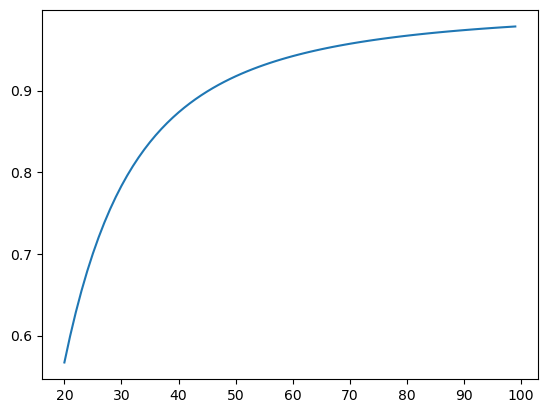

In [26]:
def fac(x):
    return Decimal(math.factorial(x))
x = 15
ys = list(range(20,100))
zs = [y*(y-1)/2 for y in ys]
ps = [fac(z)/(Decimal(z**x)*fac(z-x)) for z in zs]

plt.plot(ys,ps)

### Update DB collection "hit_results"

In [196]:
''' Update all non-disposed hits in the database with data collected from MTurk '''
""" Rejected assignments are ignored """

# we continued at 344!!!

APPROVE_PAYMENT = False # Set to true if automatically approve payment 

# for hit in hit_result_collection.find({'answers': []}):
for hit in hit_result_collection.find({'hit.HITStatus': {'$not': {'$eq': 'Disposed'}}}):
    # iterating over hits previously sent to MTurk
    print('Updating',hit['_id'],end='\r')

    try:
        hit_result_collection.update_one(
            {'_id': hit['_id']},
            {
                "$set": {
                    "hit": mt.client.get_hit(HITId = hit['_id'])['HIT'],
                    'answers': mt.get_hit_answers(hit['_id'], approve=APPROVE_PAYMENT)
                }
            })
    except Exception as e:
        print(f"Following exception occurred for hit {hit['_id']}: {e}",end='\n\n')
        continue
print('Done'+(' '*100))


Done                                                                                                    


In [197]:
# REJECT SPECIFIC ASSIGNMENT

hit_id = "3NFWQRSHWLC2QITSIBCJWQK0X02FGN"
assignment_id_rej = "39U1BHVTDTPE1VXZ8IFQIK6IVHU3TN"
print('Rejecting',hit_id,end='\r')

try: 
    hit_assignmentsList = mt.client.list_assignments_for_hit(
        HITId=hit_id,
    )

    assignments = hit_assignmentsList['Assignments']

#         Get details and results of each Assignment and add to answers array
    answers = []
    for assignment in assignments:
        worker_id = assignment['WorkerId']
        assignment_id = assignment['AssignmentId']

        if assignment_id == assignment_id_rej:
            response = mt.client.reject_assignment(
                AssignmentId=assignment_id,
#                 RequesterFeedback='Poor explanations, e.g. "Claim 3a. is false and is well-formed, grammatically correct and has...".'
                RequesterFeedback='Poor answers, assignment will be rejected and worker blocked.'
            )
            print(f"Rejection successful for assignment {assignment_id}")

except Exception as e:
    print(f"Following exception occurred for hit {hit['_id']}: {e}",end='\n\n')


Rejection successful for assignment 39U1BHVTDTPE1VXZ8IFQIK6IVHU3TN


In [288]:
### REJECT ASSIGNMENTS

for hit in hit_result_collection.find({}):
    # iterating over hits previously sent to MTurk
    print('Rejecting',hit['_id'],end='\r')
    
    try: 
        hit_assignmentsList = mt.client.list_assignments_for_hit(
            HITId=hit['_id'],
#             AssignmentStatuses=['ReviewAble']
        )

        assignments = hit_assignmentsList['Assignments']
        
#         Get details and results of each Assignment and add to answers array
        answers = []
        for assignment in assignments[:1]:
            worker_id = assignment['WorkerId']
            assignment_id = assignment['AssignmentId']
            
            response = mt.client.reject_assignment(
                AssignmentId=assignment_id,
                RequesterFeedback='Poor answers, assignment will be rejected and worker blocked.'
            )
            print(f"Rejection successful for assignment {assignment_id}",end='\n\n')
        
    except Exception as e:
        print(f"Following exception occurred for hit {hit['_id']}: {e}",end='\n\n')
        continue
print('Done'+(' '*100))



Following exception occurred for hit 30Y6N4AHZWUWHOOA7GB57UVMMZSDR6: An error occurred (RequestError) when calling the RejectAssignment operation: This operation can be called with a status of: Submitted (1679832357099)

Done                                                                                                    


________

## TODO go over this code later

#### Delete previously sent HITs

In [228]:
query = {'hit.HITStatus': {'$not': {'$eq': 'Disposed'}}}
# query['type'] = "claim_generation"
len(list(hit_result_collection.find(query)))


8

In [276]:
query = {}
# query['hit.NumberOfAssignmentsAvailable'] = 3
query['answers'] = []
query['hit.HITStatus'] = "Disposed"

len(list(hit_result_collection.find(query)))

for hit in hit_result_collection.find(query): 
    hit_result_collection.delete_many({"_id": hit["_id"]})
    print(f"HIT with id {hit['_id']} deleted.")


HIT with id 3HFWPF5ALGHA0BMQTG5YKVE6HM13SX deleted.
HIT with id 3O0M2G5VDD0DDS9VKOAQD51M3Y9499 deleted.
HIT with id 3566S7OX6KHS7AOJI9T41B3DWOB17H deleted.
HIT with id 35JDMRECDB7AK4TWN0SDE8Z0K0YGEI deleted.
HIT with id 39HYCOOPLVJ5K8BI28FOLV1CGA9DMU deleted.


In [275]:
""" If you set 'force' to TRUE, it will abort mission and force an expiry in all HITs and then delete them.
If you only want to remove the completed ones (make them Disposed so the update routine won't loop through tons of
HITs), keep it as FALSE."""

force = True

while True:
    ''' Dispose all hits in the database '''
    query = {'hit.HITStatus': {'$not': {'$eq': 'Disposed'}}} # orginally for non-disposed HITs
#     query["type"] = "claim_generation"
#     query = {'timestamp': {'$gte': datetime.datetime(2021, 6, 29)}}
    
    if not force:
        query['hit.NumberOfAssignmentsPending'] = 0
        query['hit.NumberOfAssignmentsAvailable'] = 0
    elif force:
        pass
#         query['hit.NumberOfAssignmentsPending'] = 0
#         query['hit.NumberOfAssignmentsCompleted'] = 0
    
    hit_result_collection_list = list(hit_result_collection.find(query))
    print(f"Length of retrieved HITs ", len(hit_result_collection_list))
    
    if (not force and len(hit_result_collection_list) == 0) or (force and mt.client.list_hits()['NumResults']==0):
        print('Finished')
        break
        
    for hit in hit_result_collection_list:
        try:
            mt.client.update_expiration_for_hit(HITId = hit['_id'], ExpireAt=datetime(2018, 4, 10, 7, 22, 15))
            mt.client.delete_hit(HITId = hit['_id'])
            print('Removed',hit['_id'])
        except Exception as e:
            print(hit['_id'], e)
            
            if force:
                print("force")
                try:
                    mt.client.update_expiration_for_hit(HITId = hit['_id'], ExpireAt=datetime(2018, 4, 10, 7, 22, 15))
                    mt.client.get_hit(HITId = hit['_id'])
                    mt.client.delete_hit(HITId = hit['_id'])
                    print('Removed',hit['_id'])
                except Exception as e:
                    pass
#                     print(hit['_id'],e)
                    
#                     if status == 'Reviewable':
#                     assignments = mt.client.list_assignments_for_hit(HITId=hit['_id'], AssignmentStatuses=['Reviewable'])
#                     if assignments['NumResults'] > 0:
#                         for assign in assignments['Assignments']:
#                             mt.client.approve_assignment(AssignmentId=assign['AssignmentId'])
#                     try:
#                         mt.client.delete_hit(HITId=hit['_id'])
#                     except Exception as e:
#                         pass
#                         print(hit['_id'],e)
            continue
    break
    

Length of retrieved HITs  4
Removed 3S8A4GJREA1PPMQC6D812LAXQIO6V4
Removed 33BFF6QPJ8937S3ZDLFZHKHRN0O3W5
Removed 3BVS8WK9R7TQ9SN73XQQYC6VWH3BIX
33Q5P9PUTWKVEN4NH1A79RF3AGXZCJ An error occurred (RequestError) when calling the DeleteHIT operation: This HIT is currently in the state 'Unassignable'.  This operation can be called with a status of: Reviewing, Reviewable (1679655379444)
force


In [160]:
hit_list = mt.client.list_hits()
print(f"Length of retrieved hits: {len(hit_list['HITs'])}")
force = True

for hit in hit_list["HITs"]:
    hitid = hit["HITId"]
    try:
        mt.client.update_expiration_for_hit(HITId = hitid, ExpireAt=datetime(2018, 1, 1))
        mt.client.get_hit(HITId = hitid)
        mt.client.delete_hit(HITId = hitid)
        print('Removed',hitid)
    except Exception as e:
        print(f"Following error occured while deleting HIT {hitid}, lets continue: {e}.")
        if force:
            try:
                mt.client.update_expiration_for_hit(hitid, ExpireAt=datetime(2017, 1, 1))
                mt.client.delete_hit(HITId = hitid)
                print('Removed', hitid)
            except Exception as e:
                pass
#                 print(hit['_id'],e)
        continue


Length of retrieved hits: 10
Following error occured while deleting HIT 39HYCOOPLVJ5K8BI28FOLV1CGA9DMU, lets continue: An error occurred (RequestError) when calling the DeleteHIT operation: This HIT is currently in the state 'Unassignable'.  This operation can be called with a status of: Reviewing, Reviewable (1679568928220).
Following error occured while deleting HIT 35JDMRECDB7AK4TWN0SDE8Z0K0YGEI, lets continue: An error occurred (RequestError) when calling the DeleteHIT operation: This HIT is currently in the state 'Unassignable'.  This operation can be called with a status of: Reviewing, Reviewable (1679568930537).
Following error occured while deleting HIT 3566S7OX6KHS7AOJI9T41B3DWOB17H, lets continue: An error occurred (RequestError) when calling the DeleteHIT operation: This HIT is currently in the state 'Unassignable'.  This operation can be called with a status of: Reviewing, Reviewable (1679568932272).
Following error occured while deleting HIT 3O0M2G5VDD0DDS9VKOAQD51M3Y9499,

KeyboardInterrupt: 

#### Delete specific Task

In [274]:
force = True
query = {}

while True:
    ''' Dispose all hits in the database '''
    
    if not force:
        query['hit.NumberOfAssignmentsPending'] = 0
        query['hit.NumberOfAssignmentsAvailable'] = 0
    elif force:
        query['hit.NumberOfAssignmentsPending'] = 0
    
    hit_result_collection_list = list(hit_result_collection.find(query))
    
    if (not force and len(hit_result_collection_list) == 0) or (force and mt.client.list_hits()['NumResults']==0):
        print('Finished')
        break
        
    for hit_id in hit_result_collection_list:
        try:
            mt.client.update_expiration_for_hit(HITId = hitid, ExpireAt=datetime(2018, 1, 1))
            x = mt.client.delete_hit(HITId = hit_id)
            print('Removed',hit_id["_id"])
        except Exception as e:
#             print(hit_id)
            if force:
                print("force")
                try:
                    mt.client.update_expiration_for_hit(HITId = hit_id, ExpireAt=datetime(2017, 1, 1))
                    mt.client.delete_hit(HITId = hit_id)
                    print('Removed',hit_id)
                except Exception as e:
                    pass
#                     print(hit_id,e)
            continue
    break
    

force
force
force
force
force
force
force
force


#### Update HITs

In [ ]:
hitid = '...' # TODO enter HIT_ID you want to update

mt.client.update_expiration_for_hit(HITId = hitid, ExpireAt=datetime(2015, 1, 1))

# mt.client.update_hit_review_status(HITId = hitid, Revert=True)
# mt.client.update_hit_type_of_hit(HITId = hitid, HITTypeId='1623495307575')

# mt.get_hit_answers(hitid, approve=True)
pprint(mt.client.get_hit(HITId = hitid))

### Preparing html tables for UI

In [ ]:
with open(data_folder + "TaskSets/task_sets_en_table.json",'r') as f:
    task_sets = json.load(f)
    
subset = []
for task_set in task_sets: 
    for task in task_set['taskSet']: 
        if (task['table']['header_horizontal']!=[] and any(task['table']['header_horizontal'])) or \
        (task['table']['header_vertical']!=[] and any(task['table']['header_vertical'])): 
            subset.append(task)
            
len(subset)

In [ ]:
from lxml import html
from lxml.etree import tostring


def del_col_row(table, row_i = None, col_i = None):
    """remove columns and rows from table"""

    if type(table)==str:
        table = html.fragment_fromstring(table)
        
    # remove column i
    if col_i != None:
        for row in table.getchildren()[0].iterchildren():
            row.remove(row.getchildren()[col_i])
        
    # remove row i
    if row_i != None:
        for index, row in zip(range(len(table.getchildren()[0].getchildren())), table.getchildren()[0].iterchildren()):
            if index == row_i:
                row.getparent().remove(row)
    
    return table 


In [ ]:
# EXAMPLE 1

url = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income"
resp = requests.get(url)
page = BeautifulSoup(resp.text, 'html.parser')
tables = page.findAll("table")

table = tables[3]

# TODO replace in function del_col_row() e.g. table.getchildren() by table.getchildren()[0].getchildren()
# drop columns and rows unnecessary 
table = html.tostring(del_col_row(str(table), col_i = 3)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 3)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 4)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 4)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 0)).decode('utf-8')

for i in range(8):
    table = html.tostring(del_col_row(str(table), row_i = 2)).decode('utf-8')
for i in range(6):
    table = html.tostring(del_col_row(str(table), row_i = 9)).decode('utf-8')
for i in range(35):
    table = html.tostring(del_col_row(str(table), row_i = 13)).decode('utf-8')
    
# BeautifulSoup(table)


In [ ]:
# EXAMPLE 2

url = "https://www.cdc.gov/flu/about/burden/index.html"
resp = requests.get(url)
page = BeautifulSoup(resp.text, 'html.parser')
tables = page.findAll("table")

table = tables[0]

# drop columns and rows unnecessary 
# table = html.tostring(del_col_row(str(table), col_i = None)).decode('utf-8')

for i in range(8):
    table = html.tostring(del_col_row(str(table), row_i = 0)).decode('utf-8')
    
table = html.tostring(del_col_row(str(table), col_i = 2)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 3)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 4)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 5)).decode('utf-8')

# Delete second header row.. 
table = html.fragment_fromstring(table)
table.getchildren()[1].remove(table.getchildren()[1].getchildren()[1])
# table.getchildren()[1].remove(table.getchildren()[1].getchildren()[0])

table = html.tostring(table).decode('utf-8')


In [ ]:
# EXAMPLE 3

url = "https://www.macrotrends.net/countries/AUS/australia/crime-rate-statistics"
resp = requests.get(url)
page = BeautifulSoup(resp.text, 'html.parser')
tables = page.findAll("table")
table = tables[1]


In [ ]:
# EXAMPLE 4

url = "https://www.cebm.net/covid-19/global-covid-19-case-fatality-rates"
resp = requests.get(url)
page = BeautifulSoup(resp.text, 'html.parser')
tables = page.findAll("table")
table = tables[0]


In [ ]:
# EXAMPLE 5

url = "https://www.nimh.nih.gov/health/statistics/suicide.shtml"
resp = requests.get(url)
page = BeautifulSoup(resp.text, 'html.parser')
tables = page.findAll("table")
table = tables[0]

for i in range(5):
    table = html.tostring(del_col_row(str(table), row_i = 5)).decode('utf-8')


In [ ]:
# Table Test

url = "https://en.wikipedia.org/wiki/Demographics_of_the_United_States"
resp = requests.get(url)
page = BeautifulSoup(resp.text, 'html.parser')
tables = page.findAll("table")
table = tables[23]

for i in range(5):
    table = html.tostring(del_col_row(str(table), row_i = 10)).decode('utf-8')

table = html.tostring(del_col_row(str(table), row_i = 0)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 0)).decode('utf-8')

table = html.fragment_fromstring(table)
table.getchildren()[0].getchildren()[0].remove(table.getchildren()[0].getchildren()[0].getchildren()[4])

for row in table.getchildren()[0].iterchildren():
    if row.getchildren():
#         print(f"This: {html.tostring(row.getchildren()[0])}")
        row.remove(row.getchildren()[2])
        
# table = html.tostring(del_col_row(str(table), col_i = 0)).decode('utf-8')

table = html.tostring(table).decode('utf-8')
BeautifulSoup(table)


In [ ]:
# task = subset[100]

# if not task['table']['caption']:
#     task['table']['caption'] = ''
# html_table = task['table']['html_table']

html_table_bs = BeautifulSoup(table)
# html_table_bs = table
html_table_bs = _remove_attrs(html_table_bs)
_remove_img(html_table_bs)
_remove_caption(html_table_bs)

for tag in html_table_bs.findAll(["table", "th", "td"]):
    tag['style'] = "border: 1px solid black;"

html_table = str(html_table_bs).replace("\n", "").replace("'", "\'")
# html_table_bs = BeautifulSoup(html_table)

print(html_table)


In [ ]:
# Load taskset for table task for MOCK HTML page


html_table = task_sets[i]["taskSet"][entry]['table']['html_table']
html_table = html_table.replace("\n", "")
html_table = html_table.replace("'", "\'")
# html_table = html_table.replace("%", "\%")
# html_table = html_table.replace("", "\'")

html_table_bs = BeautifulSoup(html_table)
html_table_bs = _remove_attrs(html_table_bs)
html_table_bs

### 3. Updating HITs

In [ ]:
html_table_list = []
tags = []

for table_list in test_data["tables_wikipedia_references"]:
    if table_list and type(table_list)!=float:
        for table in table_list: 
            if table and "html_table" in table and type(table["html_table"])==str:
                soup = BeautifulSoup(table["html_table"])
                tags.extend([tag.name for tag in soup.find_all()])
                html_table_list.append(table["html_table"])
            
len(html_table_list)

In [ ]:
tags = list(set(tags))
tags

#### Send some taskSets again

In [ ]:
with open(r'./data/production/TaskSets/final_table_annotation/tasksets_table_annotation_1.json', "r") as file: 
    taskset_1 = json.load(file)
    
with open(r'./data/production/TaskSets/final_table_annotation/tasksets_table_annotation_3.json', "r") as file: 
    taskset_3 = json.load(file)


In [ ]:
relevant_taskSets = []

for entry in taskset_1+taskset_3: 
    for task in entry["taskSet"]:
        if task["claim_db_id"] == "6072bd2a000ca92c09d11fb5":
            task["table"]["header_horizontal"] = []
            task["g_id"] = 3
            relevant_taskSets.append(entry)
            
        elif task["claim_db_id"] == "6072bd2d000ca92c09d145b8":
            task["g_id"] = 3
            relevant_taskSets.append(entry)

    

In [ ]:
with open(r'./data/production/TaskSets/final_table_annotation/tasksets_table_annotation_faultyHITs_updated.json', "w", encoding="utf-8") as file: 
    json.dump(relevant_taskSets, file, indent=4)
